### Gemini 2.0 flash lite VS Tuned Gemini 2.0 flash lite

In [17]:
# Cell 1: Imports and Setup
import os
import sys
import logging
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown # For displaying DataFrames and Markdown
import vertexai # Import base vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image as VertexImage # Specific imports
from google.api_core import exceptions as google_exceptions # For error handling
import inspect # To inspect function signature
# Import List and Dict for type hinting if needed, though often optional in notebooks
from typing import List, Dict, Any

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger("google.api_core").setLevel(logging.WARNING)
logging.getLogger("google.auth").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

# --- Project Path Setup ---
# Notebook is in the project root directory
project_root = os.path.abspath('.')
src_path = os.path.join(project_root, 'src')

print(f"DEBUG: Project root: {project_root}")
print(f"DEBUG: Src path: {src_path}")

if os.path.isdir(src_path):
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
        print(f"Added {src_path} to sys.path")
    else:
        print(f"{src_path} already in sys.path")
else:
    print(f"ERROR: src directory not found at {src_path}. Cannot import project modules.")
    raise FileNotFoundError(f"src directory not found at {src_path}")

# --- Import project modules ---
try:
    import config
    import utils
    # Import the specific functions needed from vllm_handler
    from vllm_handler import analyze_content, initialize_vertex_ai
    print("Project modules (config, utils, vllm_handler) imported successfully.")

    # Verify the handler has the modified function signature
    sig = inspect.signature(analyze_content)
    if 'model_id_override' not in sig.parameters:
         print("\nCRITICAL WARNING: vllm_handler.analyze_content is missing the 'model_id_override' parameter!")
         print("Please ensure src/vllm_handler.py is saved with the correct version and RESTART THE KERNEL.")
         # raise AttributeError("analyze_content function signature is incorrect.")
    else:
         print("Verified: vllm_handler.analyze_content has 'model_id_override' parameter.")

except ImportError as e:
    print(f"Error importing project modules from {src_path}: {e}")
    raise
except Exception as e:
    print(f"An unexpected error occurred loading config/utils: {e}")
    raise

print("\nSetup cell execution complete.")

DEBUG: Project root: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON
DEBUG: Src path: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src
/home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/src already in sys.path
Project modules (config, utils, vllm_handler) imported successfully.
Verified: vllm_handler.analyze_content has 'model_id_override' parameter.

Setup cell execution complete.


In [18]:
# Cell 2: Configuration & Helper Functions (UPDATED FOR PNG TESTING)
import os
import sys
import logging
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown # For displaying DataFrames and Markdown
import vertexai # Import base vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, Image as VertexImage # Specific imports
from google.api_core import exceptions as google_exceptions # For error handling
import inspect # To inspect function signature
from typing import List, Dict, Any # For type hinting

# --- Model Configuration ---
# Get model IDs from config module (ensure config is imported in Cell 1)
BASE_MODEL_ID = getattr(config, 'BASE_MODEL_ID', "gemini-2.0-flash-lite-001") # Default if not in config
# IMPORTANT: Ensure TUNED_MODEL_ID in config.py is updated with your project number!
TUNED_MODEL_ID = getattr(config, 'TUNED_MODEL_ID', None) # Get from config

if not TUNED_MODEL_ID:
    logging.error("TUNED_MODEL_ID not found or is None in config.py. Please update it.")
    # Optionally raise an error or set a placeholder that will cause a later error
    # raise ValueError("TUNED_MODEL_ID is not configured in config.py")
    TUNED_MODEL_ID = "ERROR_TUNED_MODEL_ID_NOT_SET" # Placeholder to cause error later if not overridden

# --- Input/Output Configuration ---
# Construct paths relative to project_root (defined in Cell 1)
OUTPUT_DIR_PATH = os.path.join(project_root, 'outputs')
# --- CHANGE 1: Point to PNG directory ---
INPUT_IMAGE_DIR_PATH = os.path.join(project_root, 'inputs', 'png') # Use PNG input path
# --- CHANGE 2: Set extension to PNG ---
IMAGE_EXTENSIONS = {".png"} # Focus on png for this run

# --- CHANGE 3: Update output filenames ---
COMPARISON_OUTPUT_FILENAME = "comparison_base_vs_tuned_results_png.json" # Adjust filename
GRAPH_OUTPUT_FILENAME = "comparison_base_vs_tuned_graph_png.png"
COMPARISON_TABLE_FILENAME = "comparison_base_vs_tuned_table_png.csv"

# --- Test Prompt ---
TEST_PROMPT = """


Your task is to act as an expert document analyst. Analyze the provided document content meticulously. Even if the content is very short, analyze the content itself.

Follow these steps precisely and structure your output exactly as shown using Markdown headings:

**Document Type:**
[Identify the type: e.g., Handwritten Notes, Typed Essay, Scientific Paper, Form, Receipt, General Text, PDF Page Image, Bar Chart, Line Graph, Diagram. Note if handwriting is present.]

**Summary:**
[Provide a concise 1-2 sentence summary of the main topic or purpose. For charts/graphs, describe what it represents.]

**Key Information & Localization:**
[Identify and extract crucial pieces of information (main points, arguments, data points from charts/graphs, axis labels, legends, titles, definitions, form fields/values). For EACH piece of information, describe its precise location (Text files: line/paragraph; Images/PDF pages: visual location like 'top-left', 'bar corresponding to 'Category A'', 'X-axis label', 'legend entry for Series 1'). Use bullet points for clarity.]
* [Extracted Info 1]
    * Location: [Precise location description]
    * Confidence: [High, Medium, or Low]
* [Extracted Info 2]
    * Location: [Precise location description]
    * Confidence: [High, Medium, or Low]
* ... (continue for all key pieces)

**Category:**
[Assign ONE category based on the content from this list: Lecture Notes, Essay Draft, Research Paper, Assignment Submission, Admin Form, Data Visualization, Other. If unsure, state 'Other'.]
"""

# --- Debugging Print ---
print(f"DEBUG: Using Input Image Directory: {INPUT_IMAGE_DIR_PATH}")
print(f"DEBUG: Using Base Model ID: {BASE_MODEL_ID}")
print(f"DEBUG: Using Tuned Model ID: {TUNED_MODEL_ID}")
# ---

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

# Store results for this specific comparison run
comparison_results_list = [] # Use this list within this notebook run
base_model_times = []
tuned_model_times = []

# --- Helper Functions ---

def get_image_files_in_dir(image_input_dir: str) -> List[str]:
    """Gets a list of absolute paths for specified IMAGE files in the directory."""
    files = []
    abs_image_input_dir = os.path.abspath(image_input_dir)
    print(f"DEBUG: [get_image_files_in_dir] Checking for images in: {abs_image_input_dir}")

    if not os.path.isdir(abs_image_input_dir):
        logging.error(f"Image input directory not found: {abs_image_input_dir}")
        print(f"ERROR: [get_image_files_in_dir] Image input directory not found: {abs_image_input_dir}")
        return files

    logging.info(f"Scanning for image files in: {abs_image_input_dir}")
    found_count = 0
    try:
        for filename in os.listdir(abs_image_input_dir):
            if filename.startswith('.'): continue
            _, file_extension = os.path.splitext(filename.lower())
            # Uses the IMAGE_EXTENSIONS variable defined above (now .png)
            if file_extension in IMAGE_EXTENSIONS:
                full_path = os.path.join(abs_image_input_dir, filename)
                if os.path.isfile(full_path):
                    files.append(os.path.abspath(full_path))
                    found_count += 1
                    logging.debug(f"Found image file: {full_path}")
    except Exception as e:
        logging.error(f"Error listing directory {abs_image_input_dir}: {e}")
        print(f"ERROR: [get_image_files_in_dir] Error listing directory {abs_image_input_dir}: {e}")
        return []

    logging.info(f"Found {found_count} image files in {abs_image_input_dir}.")
    print(f"DEBUG: [get_image_files_in_dir] Found {found_count} image files.")
    return files

# --- analyze_content_wrapper (uses the imported vllm_handler.analyze_content) ---
# This wrapper simplifies calling the function from the main loop and handles timing
def analyze_content_wrapper(file_path: str, model_to_use: str) -> tuple[str, float | None]:
    """
    Calls the main analysis function from vllm_handler with timing.
    Returns the result string and duration in seconds (or None if error).
    """
    start_time = time.time()
    try:
        # Ensure Vertex AI is initialized (should be done in Cell 4, but safe to check)
        # Assuming initialize_vertex_ai is imported from vllm_handler in Cell 1
        if not initialize_vertex_ai():
            return "Error: Vertex AI Not Initialized", None

        # Call the imported analyze_content function from vllm_handler
        # Assuming analyze_content is imported from vllm_handler in Cell 1
        # Use the most recent vllm_handler.py (reverted simple image handling)
        result_str = analyze_content(file_path, model_id_override=model_to_use)
        end_time = time.time()
        duration = end_time - start_time
        # Check if the result indicates an error from within analyze_content
        if result_str.startswith("Error:"):
             return result_str, None # Return error string, no valid duration
        else:
             return result_str, duration # Return success string and duration
    except NameError as ne:
         # Catch if analyze_content or initialize_vertex_ai wasn't imported correctly
         logging.error(f"NameError in wrapper: {ne}. Ensure functions are imported from vllm_handler.", exc_info=True)
         return f"Error: Wrapper NameError - {ne}", None
    except Exception as e:
        logging.error(f"Unexpected error calling analyze_content for {os.path.basename(file_path)} with model {model_to_use}: {e}", exc_info=True)
        return f"Error: Wrapper exception - {e}", None


print("\nConfiguration and Helper Functions cell execution complete (Updated for PNG).")


DEBUG: Using Input Image Directory: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png
DEBUG: Using Base Model ID: gemini-2.0-flash-lite-001
DEBUG: Using Tuned Model ID: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864

Configuration and Helper Functions cell execution complete (Updated for PNG).


In [19]:
# --- Cell 3: Get Image Files ---

# Use the IMAGE helper function and the specific IMAGE input path (defined in Cell 2)
image_files_to_test = get_image_files_in_dir(INPUT_IMAGE_DIR_PATH)

if not image_files_to_test:
    raise FileNotFoundError(f"No JPEG/JPG image files found in {INPUT_IMAGE_DIR_PATH}. Please add files to the '{INPUT_IMAGE_DIR_PATH}' directory.")
else:
    print(f"\nFound {len(image_files_to_test)} image files for comparison.")

2025-05-03 17:44:31,512 - INFO - Scanning for image files in: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png
2025-05-03 17:44:31,513 - INFO - Found 3 image files in /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png.


DEBUG: [get_image_files_in_dir] Checking for images in: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png
DEBUG: [get_image_files_in_dir] Found 3 image files.

Found 3 image files for comparison.


In [20]:
# --- Cell 4: Initialize Vertex AI ---

# Initialize Vertex AI SDK using the function from vllm_handler (imported in Cell 1)
if initialize_vertex_ai():
    print("Vertex AI SDK initialized successfully for comparison.")
else:
    print("ERROR: Vertex AI SDK initialization failed. Cannot proceed.")
    # raise RuntimeError("Vertex AI SDK failed to initialize.")

Vertex AI SDK initialized successfully for comparison.


In [21]:
# --- Cell 5: Run Comparison Analysis ---

# Use the lists defined in Cell 2
# comparison_results_list = [] # Already defined in Cell 2
# base_model_times = []
# tuned_model_times = []
files_processed_base = 0
files_processed_tuned = 0
files_error_base = 0
files_error_tuned = 0

if image_files_to_test: # Proceed only if files were found
    # --- Run Base Model ---
    logging.info(f"\n--- Running Base Model: {BASE_MODEL_ID} ---")
    total_start_time_base = time.time()
    for file_path in image_files_to_test: # file_path is absolute
        relative_path = os.path.relpath(file_path, project_root) # Get path relative to project root
        logging.info(f"Processing {relative_path} with BASE model...")

        # Use the wrapper function defined in Cell 2
        result_str_base, duration_base = analyze_content_wrapper(file_path, model_to_use=BASE_MODEL_ID)
        files_processed_base += 1

        result_entry = {
            "file": relative_path,
            "base_model_output": result_str_base,
            "base_model_time_sec": None,
            "tuned_model_output": "N/A", # Placeholder
            "tuned_model_time_sec": None, # Placeholder
        }

        if result_str_base.startswith("Error:") or duration_base is None:
            logging.error(f"Base model error for {relative_path}: {result_str_base}")
            files_error_base += 1
        else:
            base_model_times.append(duration_base)
            result_entry["base_model_time_sec"] = duration_base
            logging.info(f"Base model success for {relative_path} in {duration_base:.2f}s")

        comparison_results_list.append(result_entry) # Add entry even if error occurred
        time.sleep(0.5) # Small delay

    total_end_time_base = time.time()
    logging.info(f"Base model run finished. Total time: {total_end_time_base - total_start_time_base:.2f}s")
    logging.info(f"Base model: {files_processed_base - files_error_base} successful, {files_error_base} errors.")

    # --- Run Tuned Model ---
    logging.info(f"\n--- Running Tuned Model: {TUNED_MODEL_ID} ---")
    total_start_time_tuned = time.time()

    # Iterate through the existing results list to update entries
    for i in range(len(comparison_results_list)):
        entry_to_update = comparison_results_list[i]
        relative_path = entry_to_update["file"]
        # Reconstruct absolute path - ensure project_root is correct
        file_path = os.path.join(project_root, relative_path)

        logging.info(f"Processing {relative_path} with TUNED model...")

        # Use the wrapper function defined in Cell 2
        result_str_tuned, duration_tuned = analyze_content_wrapper(file_path, model_to_use=TUNED_MODEL_ID)
        files_processed_tuned += 1

        # Update the dictionary in the list
        entry_to_update["tuned_model_output"] = result_str_tuned
        if result_str_tuned.startswith("Error:") or duration_tuned is None:
            logging.error(f"Tuned model error for {relative_path}: {result_str_tuned}")
            files_error_tuned += 1
        else:
            tuned_model_times.append(duration_tuned)
            entry_to_update["tuned_model_time_sec"] = duration_tuned
            logging.info(f"Tuned model success for {relative_path} in {duration_tuned:.2f}s")
        time.sleep(0.5) # Small delay


    total_end_time_tuned = time.time()
    logging.info(f"Tuned model run finished. Total time: {total_end_time_tuned - total_start_time_tuned:.2f}s")
    logging.info(f"Tuned model: {files_processed_tuned - files_error_tuned} successful, {files_error_tuned} errors.")

    logging.info("\nComparison processing finished.")
else:
    print("Skipping analysis run as no input image files were found.")

2025-05-03 17:44:31,528 - INFO - 
--- Running Base Model: gemini-2.0-flash-lite-001 ---
2025-05-03 17:44:31,528 - INFO - Processing inputs/png/output.png with BASE model...
2025-05-03 17:44:31,528 - INFO - Analyzing file: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/output.png
2025-05-03 17:44:31,529 - INFO - Processing as MIME type: image/png
2025-05-03 17:44:31,530 - INFO - Prepared image part manually from PNG bytes for output.png
2025-05-03 17:44:31,530 - INFO - Using OVERRIDDEN model: gemini-2.0-flash-lite-001
2025-05-03 17:44:31,531 - INFO - Successfully loaded OVERRIDDEN model: gemini-2.0-flash-lite-001
2025-05-03 17:44:31,531 - INFO - Sending request to Vertex AI Gemini model (gemini-2.0-flash-lite-001) for file: output.png...


DEBUG: analyze_content called for: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/output.png
DEBUG: Mime type: image/png
DEBUG: Entering MANUAL PNG byte loading block for output.png
DEBUG: Manual PNG byte loading successful.
DEBUG: Using OVERRIDDEN model: gemini-2.0-flash-lite-001
DEBUG: Attempting GenerativeModel('gemini-2.0-flash-lite-001')...
DEBUG: Loaded OVERRIDDEN model successfully.
DEBUG: Sending request with model: gemini-2.0-flash-lite-001


2025-05-03 17:44:34,679 - INFO - Received response from model for file: output.png.
2025-05-03 17:44:34,680 - INFO - Analysis complete for file: output.png.
2025-05-03 17:44:34,680 - INFO - Base model success for inputs/png/output.png in 3.15s


DEBUG: Received response for output.png
DEBUG: Attempting to access response.text...
DEBUG: Accessed response.text successfully.
DEBUG: Analysis complete for output.png. Result length: 1558


2025-05-03 17:44:35,181 - INFO - Processing inputs/png/table.png with BASE model...
2025-05-03 17:44:35,182 - INFO - Analyzing file: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/table.png
2025-05-03 17:44:35,183 - INFO - Processing as MIME type: image/png
2025-05-03 17:44:35,184 - INFO - Prepared image part manually from PNG bytes for table.png
2025-05-03 17:44:35,184 - INFO - Using OVERRIDDEN model: gemini-2.0-flash-lite-001
2025-05-03 17:44:35,185 - INFO - Successfully loaded OVERRIDDEN model: gemini-2.0-flash-lite-001
2025-05-03 17:44:35,185 - INFO - Sending request to Vertex AI Gemini model (gemini-2.0-flash-lite-001) for file: table.png...


DEBUG: analyze_content called for: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/table.png
DEBUG: Mime type: image/png
DEBUG: Entering MANUAL PNG byte loading block for table.png
DEBUG: Manual PNG byte loading successful.
DEBUG: Using OVERRIDDEN model: gemini-2.0-flash-lite-001
DEBUG: Attempting GenerativeModel('gemini-2.0-flash-lite-001')...
DEBUG: Loaded OVERRIDDEN model successfully.
DEBUG: Sending request with model: gemini-2.0-flash-lite-001


2025-05-03 17:44:40,231 - INFO - Received response from model for file: table.png.
2025-05-03 17:44:40,232 - INFO - Analysis complete for file: table.png.
2025-05-03 17:44:40,232 - INFO - Base model success for inputs/png/table.png in 5.05s


DEBUG: Received response for table.png
DEBUG: Attempting to access response.text...
DEBUG: Accessed response.text successfully.
DEBUG: Analysis complete for table.png. Result length: 2962


2025-05-03 17:44:40,733 - INFO - Processing inputs/png/test.png with BASE model...
2025-05-03 17:44:40,734 - INFO - Analyzing file: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/test.png
2025-05-03 17:44:40,735 - INFO - Processing as MIME type: image/png
2025-05-03 17:44:40,736 - INFO - Prepared image part manually from PNG bytes for test.png
2025-05-03 17:44:40,736 - INFO - Using OVERRIDDEN model: gemini-2.0-flash-lite-001
2025-05-03 17:44:40,736 - INFO - Successfully loaded OVERRIDDEN model: gemini-2.0-flash-lite-001
2025-05-03 17:44:40,737 - INFO - Sending request to Vertex AI Gemini model (gemini-2.0-flash-lite-001) for file: test.png...


DEBUG: analyze_content called for: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/test.png
DEBUG: Mime type: image/png
DEBUG: Entering MANUAL PNG byte loading block for test.png
DEBUG: Manual PNG byte loading successful.
DEBUG: Using OVERRIDDEN model: gemini-2.0-flash-lite-001
DEBUG: Attempting GenerativeModel('gemini-2.0-flash-lite-001')...
DEBUG: Loaded OVERRIDDEN model successfully.
DEBUG: Sending request with model: gemini-2.0-flash-lite-001


2025-05-03 17:44:42,256 - INFO - Received response from model for file: test.png.
2025-05-03 17:44:42,257 - INFO - Analysis complete for file: test.png.
2025-05-03 17:44:42,258 - INFO - Base model success for inputs/png/test.png in 1.52s


DEBUG: Received response for test.png
DEBUG: Attempting to access response.text...
DEBUG: Accessed response.text successfully.
DEBUG: Analysis complete for test.png. Result length: 567


2025-05-03 17:44:42,759 - INFO - Base model run finished. Total time: 11.23s
2025-05-03 17:44:42,760 - INFO - Base model: 3 successful, 0 errors.
2025-05-03 17:44:42,760 - INFO - 
--- Running Tuned Model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864 ---
2025-05-03 17:44:42,760 - INFO - Processing inputs/png/output.png with TUNED model...
2025-05-03 17:44:42,761 - INFO - Analyzing file: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/output.png
2025-05-03 17:44:42,761 - INFO - Processing as MIME type: image/png
2025-05-03 17:44:42,762 - INFO - Prepared image part manually from PNG bytes for output.png
2025-05-03 17:44:42,762 - INFO - Using OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
2025-05-03 17:44:42,762 - INFO - Successfully loaded OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
2025-05-03 17:44:42,762 - INFO - Sending request to Vertex AI

DEBUG: analyze_content called for: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/output.png
DEBUG: Mime type: image/png
DEBUG: Entering MANUAL PNG byte loading block for output.png
DEBUG: Manual PNG byte loading successful.
DEBUG: Using OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
DEBUG: Attempting GenerativeModel('projects/248124319532/locations/europe-west4/endpoints/4532752078669348864')...
DEBUG: Loaded OVERRIDDEN model successfully.
DEBUG: Sending request with model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864


2025-05-03 17:44:45,263 - INFO - Received response from model for file: output.png.
2025-05-03 17:44:45,264 - INFO - Analysis complete for file: output.png.
2025-05-03 17:44:45,264 - INFO - Tuned model success for inputs/png/output.png in 2.50s


DEBUG: Received response for output.png
DEBUG: Attempting to access response.text...
DEBUG: Accessed response.text successfully.
DEBUG: Analysis complete for output.png. Result length: 1166


2025-05-03 17:44:45,765 - INFO - Processing inputs/png/table.png with TUNED model...
2025-05-03 17:44:45,766 - INFO - Analyzing file: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/table.png
2025-05-03 17:44:45,766 - INFO - Processing as MIME type: image/png
2025-05-03 17:44:45,767 - INFO - Prepared image part manually from PNG bytes for table.png
2025-05-03 17:44:45,767 - INFO - Using OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
2025-05-03 17:44:45,767 - INFO - Successfully loaded OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
2025-05-03 17:44:45,768 - INFO - Sending request to Vertex AI Gemini model (projects/248124319532/locations/europe-west4/endpoints/4532752078669348864) for file: table.png...


DEBUG: analyze_content called for: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/table.png
DEBUG: Mime type: image/png
DEBUG: Entering MANUAL PNG byte loading block for table.png
DEBUG: Manual PNG byte loading successful.
DEBUG: Using OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
DEBUG: Attempting GenerativeModel('projects/248124319532/locations/europe-west4/endpoints/4532752078669348864')...
DEBUG: Loaded OVERRIDDEN model successfully.
DEBUG: Sending request with model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864


2025-05-03 17:44:50,531 - INFO - Received response from model for file: table.png.
2025-05-03 17:44:50,531 - INFO - Analysis complete for file: table.png.
2025-05-03 17:44:50,532 - INFO - Tuned model success for inputs/png/table.png in 4.77s


DEBUG: Received response for table.png
DEBUG: Attempting to access response.text...
DEBUG: Accessed response.text successfully.
DEBUG: Analysis complete for table.png. Result length: 2840


2025-05-03 17:44:51,033 - INFO - Processing inputs/png/test.png with TUNED model...
2025-05-03 17:44:51,034 - INFO - Analyzing file: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/test.png
2025-05-03 17:44:51,034 - INFO - Processing as MIME type: image/png
2025-05-03 17:44:51,035 - INFO - Prepared image part manually from PNG bytes for test.png
2025-05-03 17:44:51,035 - INFO - Using OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
2025-05-03 17:44:51,036 - INFO - Successfully loaded OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
2025-05-03 17:44:51,036 - INFO - Sending request to Vertex AI Gemini model (projects/248124319532/locations/europe-west4/endpoints/4532752078669348864) for file: test.png...


DEBUG: analyze_content called for: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/inputs/png/test.png
DEBUG: Mime type: image/png
DEBUG: Entering MANUAL PNG byte loading block for test.png
DEBUG: Manual PNG byte loading successful.
DEBUG: Using OVERRIDDEN model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864
DEBUG: Attempting GenerativeModel('projects/248124319532/locations/europe-west4/endpoints/4532752078669348864')...
DEBUG: Loaded OVERRIDDEN model successfully.
DEBUG: Sending request with model: projects/248124319532/locations/europe-west4/endpoints/4532752078669348864


2025-05-03 17:44:52,266 - INFO - Received response from model for file: test.png.
2025-05-03 17:44:52,267 - INFO - Analysis complete for file: test.png.
2025-05-03 17:44:52,267 - INFO - Tuned model success for inputs/png/test.png in 1.23s


DEBUG: Received response for test.png
DEBUG: Attempting to access response.text...
DEBUG: Accessed response.text successfully.
DEBUG: Analysis complete for test.png. Result length: 440


2025-05-03 17:44:52,768 - INFO - Tuned model run finished. Total time: 10.01s
2025-05-03 17:44:52,769 - INFO - Tuned model: 3 successful, 0 errors.
2025-05-03 17:44:52,769 - INFO - 
Comparison processing finished.


In [22]:
# --- Cell 6: Save Full Results to JSON ---

# Save the detailed comparison results
comparison_output_path = os.path.join(OUTPUT_DIR_PATH, COMPARISON_OUTPUT_FILENAME)
if comparison_results_list: # Only save if there are results
    try:
        with open(comparison_output_path, 'w', encoding='utf-8') as f:
            json.dump(comparison_results_list, f, indent=4, ensure_ascii=False)
        print(f"Full comparison results saved to: {comparison_output_path}")
    except Exception as e:
        print(f"Error saving comparison JSON: {e}")
else:
    print("No comparison results generated to save.")

Full comparison results saved to: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/outputs/comparison_base_vs_tuned_results_png.json


In [23]:
# --- Cell 7: Create and Display Pandas DataFrame ---

if comparison_results_list:
    # Convert the list of dictionaries to a Pandas DataFrame
    comparison_df = pd.DataFrame(comparison_results_list)

    # Save the DataFrame to CSV
    comparison_table_path = os.path.join(OUTPUT_DIR_PATH, COMPARISON_TABLE_FILENAME)
    try:
        comparison_df.to_csv(comparison_table_path, index=False)
        print(f"Comparison table saved to: {comparison_table_path}")
    except Exception as e:
        print(f"Error saving comparison CSV: {e}")


    # Display the first few rows of the DataFrame in the notebook
    print("\n--- Comparison Results Table (First 5 Rows) ---")
    pd.set_option('display.max_colwidth', 100)
    pd.set_option('display.max_rows', 10)
    display(comparison_df.head())

    # Display basic stats for timing columns (ignoring NaNs)
    print("\n--- Timing Statistics (seconds per successful file) ---")
    timing_stats = comparison_df[['base_model_time_sec', 'tuned_model_time_sec']].dropna().describe()
    if not timing_stats.empty:
         display(timing_stats)
    else:
         print("No successful timing data available for statistics.")

else:
    print("No comparison results to display in DataFrame.")

Comparison table saved to: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/outputs/comparison_base_vs_tuned_table_png.csv

--- Comparison Results Table (First 5 Rows) ---


,file,base_model_output,base_model_time_sec,tuned_model_output,tuned_model_time_sec
0,inputs/png/output.png,**Document Type:**\nBar Chart\n\n**Summary:**\nThe bar chart compares the average time per image...,3.151655,**Document Type:**\nBar Chart Image\n\n**Summary:**\nThe bar chart compares the average time per...,2.503734
1,inputs/png/table.png,**Document Type:**\nTable\n\n**Summary:**\nThis table presents performance data for different Ge...,5.049999,**Document Type:**\nTable\n\n**Summary:**\nThe table displays performance metrics for different ...,4.765872
2,inputs/png/test.png,**Document Type:**\nGeneral Text\n\n**Summary:**\nThe document presents the opening lines from C...,1.523768,"**Document Type:**\nPDF Page Image\n\n**Summary:**\nThe document is a page from a book, containi...",1.233810



--- Timing Statistics (seconds per successful file) ---


,base_model_time_sec,tuned_model_time_sec
count,3.000000,3.000000
mean,3.241807,2.834472
std,1.764843,1.789108
min,1.523768,1.233810
25%,2.337712,1.868772
50%,3.151655,2.503734
75%,4.100827,3.634803
max,5.049999,4.765872


Average Time Base Model (Successful Runs): 3241.81 ms (3 files)
Average Time Tuned Model (Successful Runs): 2834.47 ms (3 files)

Comparison graph saved to: /home/harishi/common_drive/Downloads/projects/GDG_HACKATHON/outputs/comparison_base_vs_tuned_graph_png.png


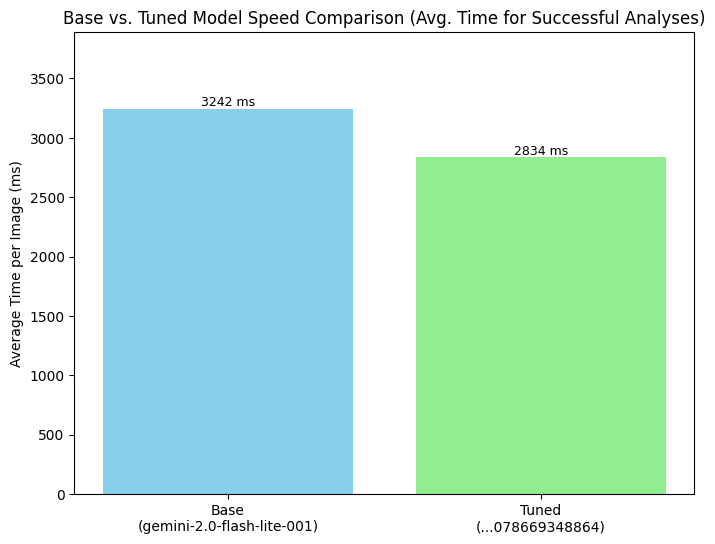

In [24]:
# --- Cell 8: Generate and Display Comparison Graph ---

# Calculate average times only from successful runs
avg_time_base_ms = None
avg_time_tuned_ms = None

if base_model_times:
    avg_time_base_ms = (sum(base_model_times) / len(base_model_times)) * 1000 # Convert to ms
    print(f"Average Time Base Model (Successful Runs): {avg_time_base_ms:.2f} ms ({len(base_model_times)} files)")
else:
    print("No successful runs recorded for the base model.")

if tuned_model_times:
    avg_time_tuned_ms = (sum(tuned_model_times) / len(tuned_model_times)) * 1000 # Convert to ms
    print(f"Average Time Tuned Model (Successful Runs): {avg_time_tuned_ms:.2f} ms ({len(tuned_model_times)} files)")
else:
    print("No successful runs recorded for the tuned model.")


# Plotting only if both models had successful runs
if avg_time_base_ms is not None and avg_time_tuned_ms is not None:
    # Use more descriptive labels
    models = [f'Base\n({BASE_MODEL_ID})', f'Tuned\n(...{TUNED_MODEL_ID[-12:]})'] # Show last part of tuned ID
    avg_times = [avg_time_base_ms, avg_time_tuned_ms]

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(models, avg_times, color=['skyblue', 'lightgreen'])
    ax.set_ylabel('Average Time per Image (ms)')
    ax.set_title('Base vs. Tuned Model Speed Comparison (Avg. Time for Successful Analyses)')
    ax.set_ylim(0, max(avg_times) * 1.2)

    # Add text labels to bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.0f} ms', va='bottom', ha='center', fontsize=9)

    # Save the graph
    graph_path = os.path.join(OUTPUT_DIR_PATH, GRAPH_OUTPUT_FILENAME)
    try:
        plt.savefig(graph_path)
        print(f"\nComparison graph saved to: {graph_path}")
    except Exception as e:
        print(f"\nError saving comparison graph: {e}")

    # Display the plot inline in the notebook
    plt.show()

else:
    print("\nCannot generate time comparison graph: Insufficient successful runs for one or both models.")